# NDVI & SAVI Machine Learning Analysis for Vegetation Change Detection

This notebook performs unsupervised machine learning analysis on NDVI and SAVI difference rasters to identify areas of potential landscape disturbance. These rasters reflect one year of vegetation change and are calculated as:

- **NDVI Difference** = NDVI (2025) − NDVI (2024)  
- **SAVI Difference** = SAVI (2025) − SAVI (2024)

The difference rasters are treated as input features for a KMeans clustering algorithm. The goal is to segment the landscape based on patterns of vegetation change and highlight zones of potential archaeological or environmental interest.

This notebook assumes that raster preprocessing and differencing were completed in `ndvi_savi_change_analysis.ipynb`, and begins by loading those exported difference rasters.


In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt

# Raster and geospatial
import rasterio
from rasterio.plot import show

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Warnings
import warnings
warnings.filterwarnings('ignore')


## Load NDVI and SAVI Difference Rasters

This section loads the exported NDVI and SAVI difference rasters generated in the previous notebook (`ndvi_savi_change_analysis.ipynb`). These rasters are spatially aligned and will serve as input features for the machine learning model.

Both rasters are expected to:
- Be in GeoTIFF format
- Have matching dimensions
- Share the same CRS and affine transform

These conditions ensure that pixel values from NDVI and SAVI represent the same spatial location and can be meaningfully compared during clustering.


In [2]:
import os
import rasterio

# Define site and base diff output path
site_id = "5HF737"
diff_dir = os.path.join("..", "data", site_id, "diff_outputs")

# Define file paths
ndvi_diff_path = os.path.join(diff_dir, "ndvi_diff_2025_2024.tif")
savi_diff_path = os.path.join(diff_dir, "savi_diff_2025_2024.tif")

# Load NDVI difference
with rasterio.open(ndvi_diff_path) as src:
    ndvi_diff = src.read(1)
    diff_meta = src.meta  # Save metadata for later export if needed

# Load SAVI difference
with rasterio.open(savi_diff_path) as src:
    savi_diff = src.read(1)


In [3]:
print("NDVI diff shape:", ndvi_diff.shape)
print("SAVI diff shape:", savi_diff.shape)

NDVI diff shape: (109, 136)
SAVI diff shape: (109, 136)


## Prepare Feature Matrix for Machine Learning

Raster data is inherently spatial, but most machine learning algorithms require a flat, tabular input structure. In this step, we will:

- Flatten the NDVI and SAVI difference rasters into 1D arrays
- Stack them into a 2D NumPy array where:
  - Each row represents a pixel (observation)
  - Each column represents a feature (NDVI difference, SAVI difference)

Since no slope masking is applied in this version, all pixels will be included unless they contain `NaN` values from earlier processing. If any such values exist, they will be removed to avoid disrupting the clustering process.


In [4]:
# Flatten the NDVI and SAVI difference rasters
ndvi_flat = ndvi_diff.flatten()
savi_flat = savi_diff.flatten()

# Stack into a 2D feature array
X = np.stack((ndvi_flat, savi_flat), axis=1)

# Remove rows where either NDVI or SAVI is NaN
valid_mask = ~np.isnan(X).any(axis=1)
X_clean = X[valid_mask]

print("Original pixels:", X.shape[0])
print("Valid pixels after removing NaNs:", X_clean.shape[0])


Original pixels: 14824
Valid pixels after removing NaNs: 14824


## Unsupervised Clustering with KMeans

We now apply KMeans clustering to group pixels based on their NDVI and SAVI difference values. Each cluster represents a distinct pattern of vegetation change, helping to segment the landscape into meaningful categories.

Before clustering, we scale the feature values using `StandardScaler` to ensure that both indices (NDVI and SAVI) contribute equally to the model. We then fit a KMeans model using a small number of clusters (e.g., 3–5) to capture general vegetation change trends.

This approach can help identify zones of:
- Significant vegetation loss
- Significant vegetation gain
- Minimal or no change

Such patterns may correspond to areas of environmental concern or potential archaeological interest.

In [5]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Apply KMeans
n_clusters = 4  # you can experiment with this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Show how many pixels per cluster
unique, counts = np.unique(labels, return_counts=True)
print("Pixels per cluster:")
for i, count in zip(unique, counts):
    print(f"Cluster {i}: {count} pixels")


Pixels per cluster:
Cluster 0: 7518 pixels
Cluster 1: 4264 pixels
Cluster 2: 2025 pixels
Cluster 3: 1017 pixels


## Reconstruct Cluster Labels into Raster Format

The KMeans model returns a 1D array of cluster labels corresponding to each valid (non-NaN) pixel. To visualize the results spatially, we need to map those labels back into their original 2D raster layout.

In this step, we will:
- Create a 2D raster initialized with `NaN` values
- Insert the cluster labels into their correct positions using the `valid_mask`
- Visualize the output using a categorical colormap to distinguish clusters

The resulting map highlights spatial patterns in vegetation change based on the unsupervised clustering.

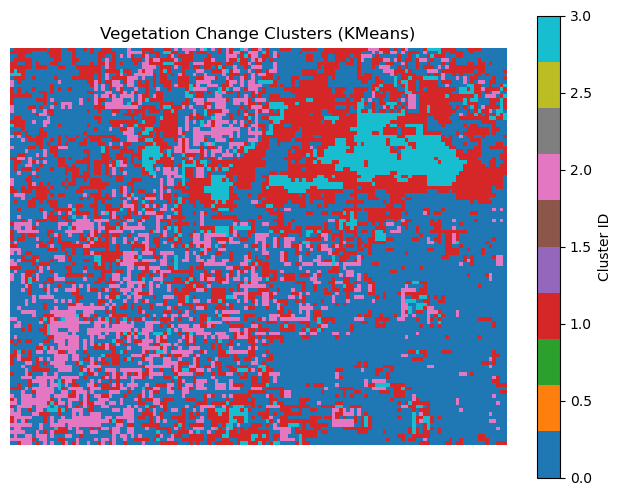

In [6]:
# Get original raster shape
rows, cols = ndvi_diff.shape

# Initialize an array filled with NaNs
cluster_raster = np.full((rows * cols), np.nan)

# Insert cluster labels into the valid (non-NaN) positions
cluster_raster[valid_mask] = labels

# Reshape back to 2D
cluster_raster = cluster_raster.reshape((rows, cols))

# Plot the cluster raster
plt.figure(figsize=(8, 6))
plt.imshow(cluster_raster, cmap='tab10')  # tab10 is good for categorical values
plt.colorbar(label='Cluster ID')
plt.title("Vegetation Change Clusters (KMeans)")
plt.axis('off')
plt.show()


## Interpreting KMeans Clusters

After applying KMeans clustering to the NDVI and SAVI difference rasters, we evaluated the mean NDVI and SAVI change within each cluster to interpret what each group represents.

These interpretations are based on the **direction and magnitude** of vegetation change over a one-year period:

- **Cluster 2**: High positive NDVI and SAVI differences → **Vegetation Gain**
- **Cluster 1**: Strong negative NDVI and SAVI differences → **Vegetation Loss**
- **Cluster 0**: Near-zero NDVI and SAVI differences → **Stable Vegetation**
- **Cluster 3**: Slight negative NDVI and SAVI differences → **Slight Decline**

> ⚠️ **Note:** Cluster IDs are arbitrary. Their meanings are derived statistically after clustering by analyzing the feature values within each group.

This approach enables segmentation of the landscape into zones that exhibit similar patterns of vegetation change — a valuable tool for identifying areas of potential environmental or archaeological interest.


In [11]:
# Append cluster labels to the feature array for interpretation
clustered_data = np.hstack((X_clean, labels.reshape(-1, 1)))

# Calculate the mean NDVI and SAVI difference per cluster
for i in range(n_clusters):
    cluster_values = clustered_data[clustered_data[:, 2] == i]
    mean_ndvi = np.mean(cluster_values[:, 0])
    mean_savi = np.mean(cluster_values[:, 1])
    print(f"Cluster {i}: Mean NDVI diff = {mean_ndvi:.4f}, Mean SAVI diff = {mean_savi:.4f}")


Cluster 0: Mean NDVI diff = 0.0126, Mean SAVI diff = 0.0190
Cluster 1: Mean NDVI diff = 0.0494, Mean SAVI diff = 0.0741
Cluster 2: Mean NDVI diff = -0.0437, Mean SAVI diff = -0.0655
Cluster 3: Mean NDVI diff = 0.1088, Mean SAVI diff = 0.1631


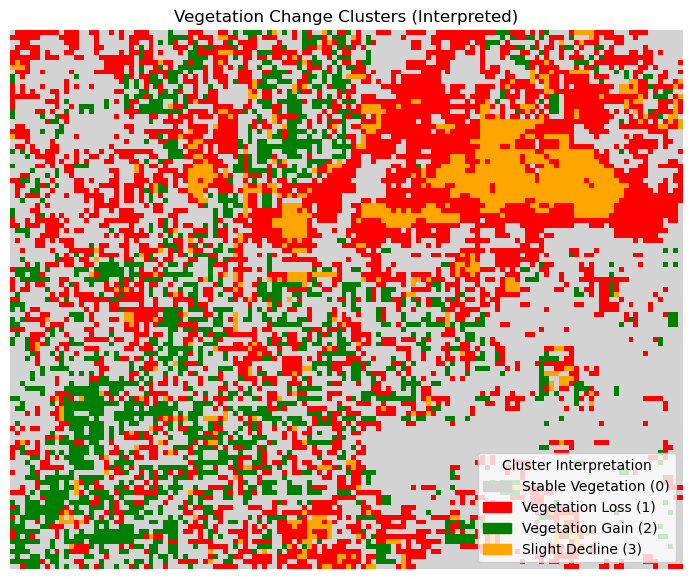

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Define colors for your 4 clusters (adjust as needed)
# Order: Cluster 0, 1, 2, 3
colors = ['lightgray', 'red', 'green', 'orange']
labels_meaning = [
    'Stable Vegetation (0)',
    'Vegetation Loss (1)',
    'Vegetation Gain (2)',
    'Slight Decline (3)'
]

# Create colormap and legend handles
cmap = ListedColormap(colors)
handles = [mpatches.Patch(color=colors[i], label=labels_meaning[i]) for i in range(n_clusters)]

# Plot the cluster map
plt.figure(figsize=(10, 7))
plt.imshow(cluster_raster, cmap=cmap)
plt.title("Vegetation Change Clusters (Interpreted)")
plt.axis('off')
plt.legend(handles=handles, loc='lower right', title="Cluster Interpretation")
plt.show()


In [14]:
plt.savefig("../outputs/5HF737_cluster_map.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## Conclusion

This notebook demonstrated an unsupervised machine learning workflow to detect and classify vegetation change using NDVI and SAVI difference rasters. By applying KMeans clustering to these indices, we segmented the landscape into zones of vegetation gain, loss, stability, and slight decline.

While this version of the notebook omits slope masking for simplicity, the final outputs used in the poster presentation were generated using terrain-filtered rasters. Slope masking was found to significantly improve the interpretability of clustering results by reducing natural variation in steep terrain.

This notebook serves as a foundation for further refinement, including:
- Reintroducing slope masking
- Expanding to additional sites
- Comparing clustering with supervised or semi-supervised methods
- Integrating results into long-term archaeological monitoring pipelines